### Assignment 6 Time Series on SP500 Analysis 2019 -2024
#### Name : Olivia Rumere
#### Date : February 23, 2025

### 1. Import Necessary Package

In [ ]:
#pip install yfinance

In [ ]:
#pip install pmdarima

In [ ]:
#pip install arch

In [ ]:
#!pip install numpy==1.26.4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from random import gauss

### 2) Data Import S&P 500 from 2019 to 2024

#### 1: Select the data [2019.01.01 - 2024.04.25] and generate the time series plot. Generate ACF and PACF from both raw log return and squared log return, respectively. Make comments based on your observation.

In [ ]:
spy = yf.Ticker("SPY")
hist = spy.history(start = "2019-01-01", end = "2024-04-25")
df = pd.DataFrame(hist, columns=['Close'])
print(df.head())
print(df.tail())

                                Close
Date                                 
2019-01-02 00:00:00-05:00  227.637482
2019-01-03 00:00:00-05:00  222.205429
2019-01-04 00:00:00-05:00  229.648331
2019-01-07 00:00:00-05:00  231.459030
2019-01-08 00:00:00-05:00  233.633667
                                Close
Date                                 
2024-04-18 00:00:00-04:00  494.726013
2024-04-19 00:00:00-04:00  490.407898
2024-04-22 00:00:00-04:00  494.924103
2024-04-23 00:00:00-04:00  500.797180
2024-04-24 00:00:00-04:00  500.559479


In [ ]:
# Convert prices to log returns
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)

Text(0.5, 1.0, 'Log Returns of S&P 500 Over Time')

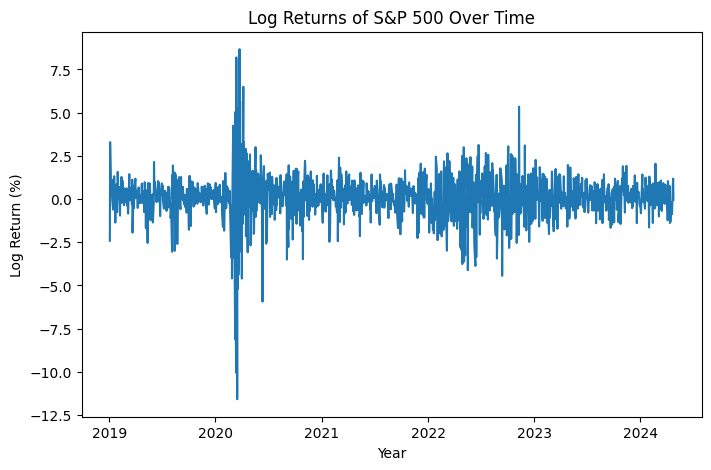

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df['Return'])
plt.ylabel("Log Return (%)")
plt.xlabel("Year")
plt.title("Log Returns of S&P 500 Over Time")

This chart shows daily log returns of the S&P 500 from 2019 to 2024. There is a large spike in volatility around early 2020 (Perhaps related with market crash due to pandemic covid), with returns ranging from about -12.5% to +7.5%. After this period, the changes in log returns seem smaller, but there are still some moments of increased volatility.

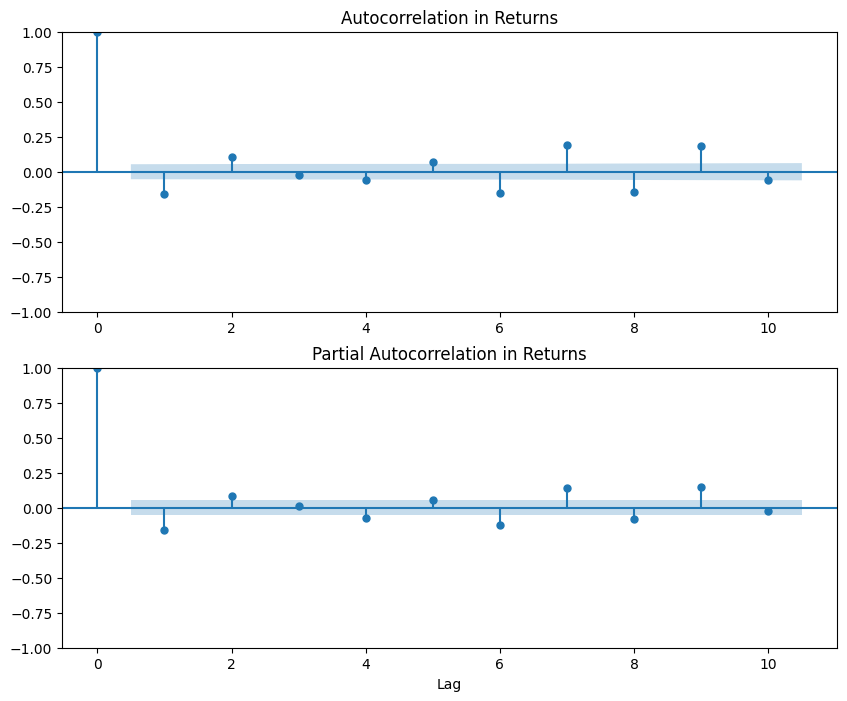

In [ ]:
diff_ts = df['Return'].iloc[1:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-1, 1)
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-1, 1)
ax2.set_xlabel("Lag")
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

The plot above show the autocorrelation (top) and partial autocorrelation (bottom) of daily returns. Both are mostly near zero at all lags, suggesting that the returns are not strongly correlated over time. This means that knowing past returns does not help much in predicting future returns. Such a pattern is common in many financial time series, which often behave like random noise.

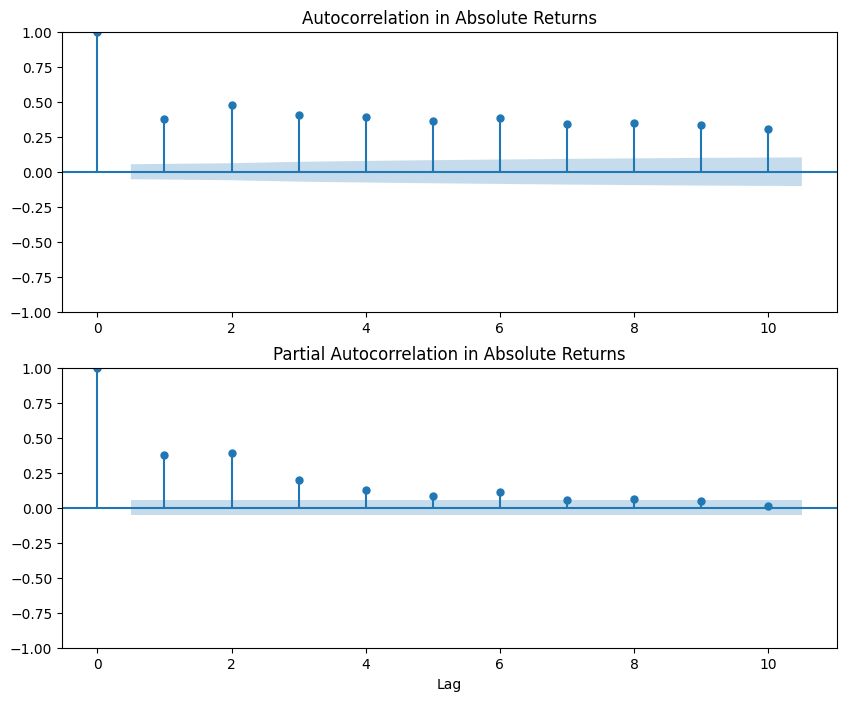

In [ ]:
abs_returns = diff_ts.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-1, 1)
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-1, 1)
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")

plt.show();

These plots show the autocorrelation (top) and partial autocorrelation (bottom) of absolute returns. The strong spike at lag 1 suggests that large price movements on one day tend to be followed by large movements the next day, this can be a sign of volatility. Even after accounting for other lags, the partial autocorrelation remains significant, this indicate that volatility may strong.

In conclusion, it seems like there is an issues on heterodescacity, so we need to check using McLeod-Li test

In [ ]:
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value

test_stat, p_value = mcleod_li_test(diff_ts, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

McLeod-Li test statistic:  780.9527039177402
p-value:  0.0


The McLeod-Li test above shows a large test statistic at about 781 and the p-value of 0.0 strongly suggest that the variance of the series is not constant over time. Thus, ARCH/GARCH model is suitable for this case

#### 2: Split the data (80% training and 20% testing) and fit a total of four models – ARCH(1), ARCH(2), GARCH(1,1) and GARCH(2,2). Then choose the best one (based on your opinion). Make comments based on your observation.

In [ ]:
# Training and testing data split of 80%/20%, with more recent historical data serving as the test set.
y_train, y_test = train_test_split(diff_ts, train_size= 0.8)

##### ARCH(1) Model

In [ ]:
arch1_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=0, rescale=False)
res_arch1 = arch1_mod.fit()
print(res_arch1.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: 2657.8343485376618
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1904.583252784078
Iteration:      3,   Func. Count:     15,   Neg. LLF: 1742.364597961813
Iteration:      4,   Func. Count:     18,   Neg. LLF: 1741.95353806033
Iteration:      5,   Func. Count:     21,   Neg. LLF: 1741.9294744251754
Iteration:      6,   Func. Count:     24,   Neg. LLF: 1741.9243466843436
Iteration:      7,   Func. Count:     27,   Neg. LLF: 1741.9243407062133
Iteration:      8,   Func. Count:     29,   Neg. LLF: 1741.924340706154
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1741.9243407062133
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 8
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:

##### ARCH(2) Model

In [ ]:
arch2_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=2, q=0, rescale=False)
res_arch2 = arch2_mod.fit()
print(res_arch2.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2303.4473002605364
Iteration:      2,   Func. Count:     12,   Neg. LLF: 117915.91032387048
Iteration:      3,   Func. Count:     17,   Neg. LLF: 5266.874050111561
Iteration:      4,   Func. Count:     22,   Neg. LLF: 1665.107962449471
Iteration:      5,   Func. Count:     26,   Neg. LLF: 1718.8443608496725
Iteration:      6,   Func. Count:     31,   Neg. LLF: 1658.3984368122638
Iteration:      7,   Func. Count:     35,   Neg. LLF: 1657.2807276812623
Iteration:      8,   Func. Count:     39,   Neg. LLF: 1657.1047096167285
Iteration:      9,   Func. Count:     43,   Neg. LLF: 1657.0909671553472
Iteration:     10,   Func. Count:     47,   Neg. LLF: 1657.0903414510449
Iteration:     11,   Func. Count:     51,   Neg. LLF: 1657.0896795624403
Iteration:     12,   Func. Count:     55,   Neg. LLF: 1657.0896765926477
Iteration:     13,   Func. Count:     58,   Neg. LLF: 1657.089676592638
Optimization terminated successfully    (Exit mode 0)


##### GARCH (1,1) Model

In [ ]:
garch11_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch11 = garch11_mod.fit()
print(res_garch11.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5768.989603663704
Iteration:      2,   Func. Count:     14,   Neg. LLF: 100686592.35483442
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1597.516594720216
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1696.311742650528
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1596.8176844902778
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1596.817593316209
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1596.8175837430758
Iteration:      8,   Func. Count:     43,   Neg. LLF: 1596.8175837430758
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1596.8175837430758
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared

##### GARCH (2,2) Model

In [ ]:
garch22_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=2, q=2, rescale=False)
res_garch22 = garch22_mod.fit()
print(res_garch22.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2657.834348732398
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2439.168927740514
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1735.4858231283708
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1641.9755472762777
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1596.735041049463
Iteration:      6,   Func. Count:     47,   Neg. LLF: 1596.638436274418
Iteration:      7,   Func. Count:     54,   Neg. LLF: 1595.2239002962215
Iteration:      8,   Func. Count:     60,   Neg. LLF: 1595.198224505661
Iteration:      9,   Func. Count:     66,   Neg. LLF: 1595.1977016262808
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1595.1967014218735
Iteration:     11,   Func. Count:     78,   Neg. LLF: 1595.1965176903727
Iteration:     12,   Func. Count:     84,   Neg. LLF: 1595.1964966316432
Iteration:     13,   Func. Count:     90,   Neg. LLF: 1595.1964960611786
Optimization terminated successfully    (Exit mode 0)
  

Among the 4 model above, we choose the best model based on the lowest AIC and BIC. From the result, we see that GARCH(1,1) is the best with AIC at 3199.64 and BIC at 3214.56.

In [ ]:
horizon = len(y_test)

forecast_arch1 = res_arch1.forecast(horizon=horizon, reindex=False)
forecast_arch2 = res_arch2.forecast(horizon=horizon, reindex=False)
forecast_garch11 = res_garch11.forecast(horizon=horizon, reindex=False)
forecast_garch22 = res_garch22.forecast(horizon=horizon, reindex=False)

vol_forecast_arch1 = np.sqrt(forecast_arch1.variance.values[-1, :])
vol_forecast_arch2 = np.sqrt(forecast_arch2.variance.values[-1, :])
vol_forecast_garch11 = np.sqrt(forecast_garch11.variance.values[-1, :])
vol_forecast_garch22 = np.sqrt(forecast_garch22.variance.values[-1, :])

# Use the absolute returns as a proxy for the realized volatility.
realized_vol = np.abs(y_test)

# Calculate RMSE for each model on testing data.
rmse_arch1 = np.sqrt(mean_squared_error(realized_vol, vol_forecast_arch1))
rmse_arch2 = np.sqrt(mean_squared_error(realized_vol, vol_forecast_arch2))
rmse_garch11 = np.sqrt(mean_squared_error(realized_vol, vol_forecast_garch11))
rmse_garch22 = np.sqrt(mean_squared_error(realized_vol, vol_forecast_garch22))

print("RMSE for ARCH(1):", rmse_arch1)
print("RMSE for ARCH(2):", rmse_arch2)
print("RMSE for GARCH(1,1):", rmse_garch11)
print("RMSE for GARCH(2,2):", rmse_garch22)

print('ARCH(1): AIC =', res_arch1.aic, ', BIC =', res_arch1.bic)
print('\nARCH(2): AIC =', res_arch2.aic, ', BIC =', res_arch2.bic)
print('\nGARCH(1, 1): AIC =', res_garch11.aic, ', BIC =', res_garch11.bic)
print('\nGARCH(2, 2): AIC =', res_garch22.aic, ', BIC =', res_garch22.bic)


RMSE for ARCH(1): 0.9683516520573493
RMSE for ARCH(2): 1.003174794786313
RMSE for GARCH(1,1): 1.028637827428793
RMSE for GARCH(2,2): 0.9998046366131167
ARCH(1): AIC = 3487.8486814124267 , BIC = 3497.795767451467

ARCH(2): AIC = 3320.1793531852954 , BIC = 3335.0999822438557

GARCH(1, 1): AIC = 3199.6351674861517 , BIC = 3214.555796544712

GARCH(2, 2): AIC = 3200.392992122357 , BIC = 3225.260707219958


The ARCH(1) model shows the lowest RMSE on the test data, but its AIC and BIC are much higher compared to the GARCH models. In contrast, the GARCH(1,1) model has the lowest AIC and BIC, indicating a better in-sample fit, and its test RMSE is very close to that of the ARCH(1) model. Overall, the GARCH(1,1) model appears to be the best balance between in-sample performance and out-of-sample forecasting accuracy

#### 3) Perform McLeod-Li Test and Jarque-Bera Test (no need to do them four times!). Make comments based on your observation.

##### McLeod-Li Test

In [52]:
# Extract standardized residuals from the fitted model
std_res_garch11 = res_garch11.resid / res_garch11.conditional_volatility

# McLeod-Li test
ml_stat, ml_p = mcleod_li_test(std_res_garch11, k=50)
print("McLeod-Li test statistic on standardized residuals:", ml_stat)
print("McLeod-Li p-value on standardized residuals:", ml_p)

# Jarque-Bera
from statsmodels.stats.stattools import jarque_bera
jb_stat, jb_p, _, _ = jarque_bera(std_res_garch11)
print("Jarque-Bera test statistic on standardized residuals:", jb_stat)
print("Jarque-Bera p-value on standardized residuals:", jb_p)


McLeod-Li test statistic on standardized residuals: 1018.3813992804018
McLeod-Li p-value on standardized residuals: 0.0
Jarque-Bera test statistic on standardized residuals: 188.67788020931928
Jarque-Bera p-value on standardized residuals: 1.0693475627901046e-41


The results above indicate that even after fitting our model, there are still some issues. The McLeod-Li test statistic of 1018.38 with a p-value of 0 shows that the squared standardized residuals still have strong autocorrelation, which suggest that there are persistent ARCH effects that the model hasn't fully captured. Similarly, the Jarque-Bera test shows a statistic of 188.68 with an extremely small p-value, suggesting that the residuals are far from normally distributed and likely have heavy tails or skewness.

#### 4) Make a One-step ahead rolling forecast on testing sample based on your final model. Make comments based on your observation.

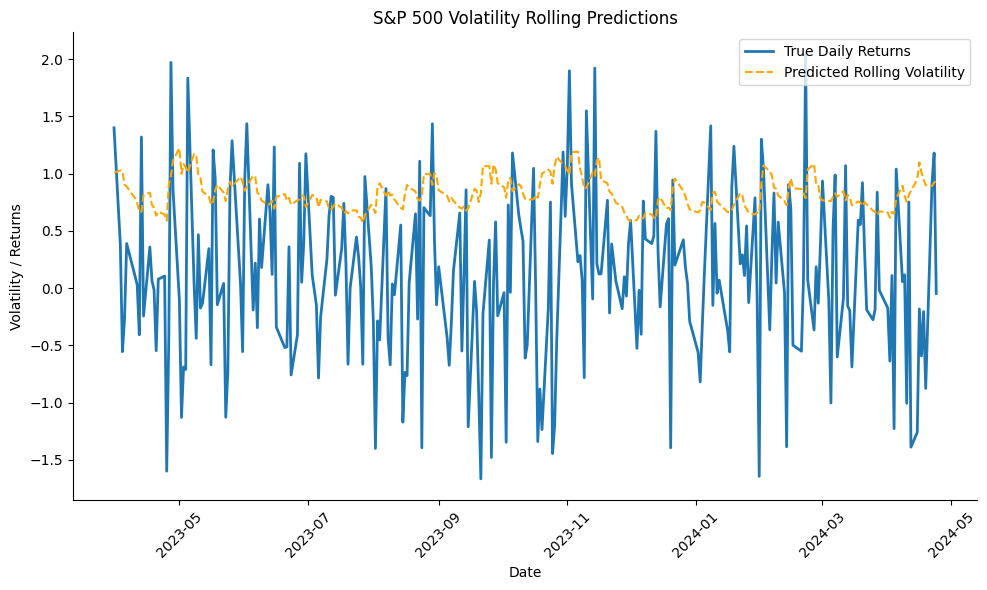

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
true_returns = diff_ts[-len(y_test):]
ax.plot(true_returns.index, true_returns, label='True Daily Returns', linewidth=2)
ax.plot(y_test.index, rolling_preds, label='Predicted Rolling Volatility', color='orange', linestyle='--')
ax.set_title("S&P 500 Volatility Rolling Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility / Returns")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The chart above compares actual daily returns (blue line) to predicted rolling volatility (orange dashed line). The predicted volatility remains in a narrower range, while the actual returns show sharper swings. Overall, the model captures some general volatility trends but does not fully account for the extreme highs and lows in returns.

This indicates that, there is still some room for improvement in our ARCH/GARCH model